In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
from importlib import reload
import sys
#import weibull
import scipy.optimize as optimization
sys.path.append('../../..')

import stlstuff as sls
import imagestuff as ims
import statstuff as sts
import retrievestuff as rs

CUDA not available.


In [3]:
%matplotlib notebook

The next cell has parameters that might change from crystal to crystal

In [4]:
# Loading in the compressed data
Segmentname = 'Segments4'
Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# Histogram accumulation
accumlist = [] # all

# Parameters for binning
Z2minforhist = 0.0
Z2maxforhist = .045
Z2offset = 0.0001
nbins_max = 8
levels = 3

Segments4_compr_flat_filt.npz


In [5]:
# # Loading in the compressed data
# Segmentname = 'Segments2'
# Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# # Histogram accumulation
# accumlist = [] # all

# # Parameters for binning
# Z2minforhist = 0.0
# Z2maxforhist = .25
# Z2offset = 0.001
# nbins_max = 8
# levels = 3

In [6]:
# Derivative names
Roughnessfilename = Flattenedfilename[0:-4]+'_roughness.jpg'; print(Roughnessfilename)
flattenedfile = np.load(Flattenedfilename)
xgridtot = flattenedfile['xgridtot']
ygridtot = flattenedfile['ygridtot']
zgridtot = flattenedfile['zgridtot']
nsegments = (len(xgridtot)); print(nsegments)

# This folder
cwd = os.getcwd(); i = cwd.index('crystals'); case_and_folder = cwd[i+9:]; print(case_and_folder)

Segments4_compr_flat_filt_roughness.jpg
1
2019-07-02\case2.1


In [7]:
# Histogram accumulation
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
plotthisone = accumlist
print('Accumulating segments', accumlist)
print('Plotting segments', plotthisone)

# Parameters for binning
print('Z2 ranging from', Z2minforhist, 'to', Z2maxforhist)
print('Max number of bins specified is', nbins_max)
Ntot = np.size(zgridtot[0]) # Just using the first one for a size estimate
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2bins = np.linspace(Z2minforhist,Z2maxforhist,nbins); #print(Z2bins)
Z2theory = np.linspace(Z2minforhist,Z2maxforhist,50); Z2theory=Z2theory[1:] # This is for Weibull plots
print('Using levels =', levels, 'for uncertainty analysis')


Accumulating segments [0]
Plotting segments [0]
Z2 ranging from 0.0 to 0.045
Max number of bins specified is 8
Sturges rule says maxbins = 12
Using nbins =  8
Using levels = 3 for uncertainty analysis


Original =  2688
4 0 672 [252 153 107  55  35  24  16]
4 1 672 [253 153  94  63  35  26  13]
4 2 672 [256 134 103  60  45  21  16]
4 3 672 [268 130  98  67  39  23  10]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.014857782244598206
statsigma =  0.12189250282358717

****Working on segment 0


<IPython.core.display.Javascript object>


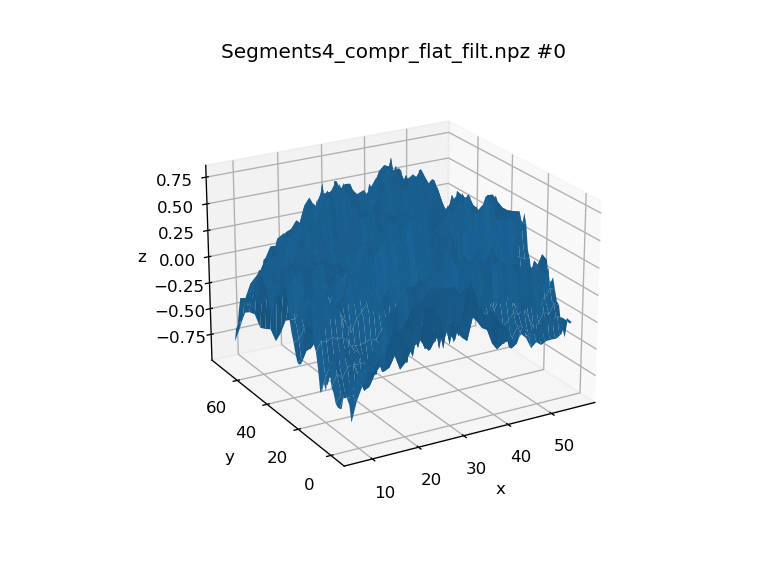

std dev of height =  0.3378509613599721
integral =  0.0050616488258700895


<IPython.core.display.Javascript object>


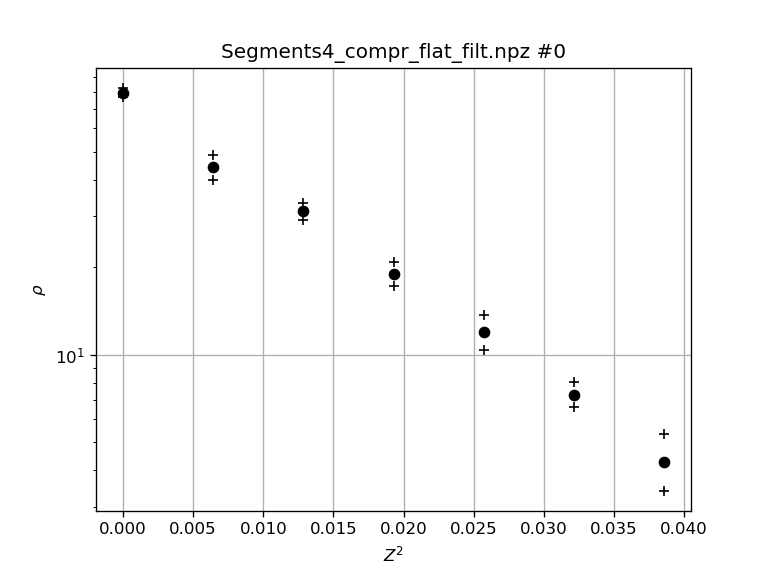

[77.10026003 40.04546652 29.17319799 17.27411763 10.40108628  6.58439984
  3.40718184]


NameError: name 'weibull' is not defined

In [8]:
# Arrays for accumulating 
counts_list = []
meanZ2_list = []
Z2flat_list = []

# First-guess for Weibull fitting (sigma2W, etaW)
x0 = np.array([.1,.9])

# Looping over segments
for isegment in range(nsegments):

    # Pull out the next segment
    sollast = zgridtot[isegment]
    xgrid = xgridtot[isegment] 
    ygrid = ygridtot[isegment]
    Ny, Nx = np.shape(sollast); #print(sollast.shape)
    Ntot = np.size(sollast)
    dx = xgrid[0,1]-xgrid[0,0]; #print('dx =', dx)
    dy = ygrid[1,0]-ygrid[0,0]; #print('dy =', dy)

    # Get the probability distribution in Z2
    counts, bins, meanZ2, Z2flat, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=levels)
    print('meanZ2 = ', meanZ2)
    print('statsigma = ', np.sqrt(meanZ2))

    # Plot if we want
    if isegment in plotthisone:
        
        # Reporting
        print('')
        print('****Working on segment', isegment)
        
        # Graph the surface
        fig1 = plt.figure()
        ax = fig1.add_subplot(111, projection='3d')
        ax.plot_surface(xgrid, ygrid, sollast)
        title = Flattenedfilename+' #'+str(isegment)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title(title)
        ax.view_init(azim=-120,elev=22)
        
        # Normalize the distribution function, report stats
        integral_rho = np.trapz(counts, bins)
        print ('std dev of height = ', np.std(sollast))
        print('integral = ', integral_rho)
        counts = counts/integral_rho
        error = error/integral_rho

        # Graph the probability
        plt.figure()
        plt.semilogy(bins, counts, 'ok')
        countsplus = counts+error; #print(countsplus)
        countsminus = counts**2/countsplus; print(countsminus)
        plt.semilogy(bins, countsplus, '+k')
        plt.semilogy(bins, countsminus,'+k')
        plt.title(title)
        plt.xlabel(r'$Z^{2}$')
        plt.ylabel(r'$\rho$')
        plt.grid(True)
        
        # Eliminate entries greater than a threshold (not sure if this is necessary)
        ikeep = np.argwhere(Z2flat < Z2maxforhist)
        Z2flat_new = np.squeeze(Z2flat[ikeep])

        # Attempt a best-fit based on the raw data
        analysis = weibull.Analysis(Z2flat_new)
        analysis.fit(method='mle')
        etaW = analysis.beta
        sigma2W = analysis.eta
        sigmaW = np.sqrt(sigma2W)
        print('Based on raw data: sigmaW, etaW = ', sigmaW, etaW)
        
        # Attempt a best-fit based on the bins
        errors = np.log(countsplus/counts); #print(errors)
        solution, solutionerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(counts),x0,sigma=errors)
        etaW = solution[1]
        sigma2W = solution[0]
        sigmaW = np.sqrt(sigma2W)
        print('Based on bins: sigmaW, etaW = ', sigmaW, etaW)
        
        # Graph the best-fit probability
        myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)
        plt.semilogy(Z2theory, myWeibull, 'b',label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:5])
        plt.legend()
        
    # Accumulate if we want
    if isegment in accumlist:
        counts_list.append(counts)
        meanZ2_list.append(meanZ2)
        Z2flat_list.append(Z2flat)

In [9]:
# Sum up the accumulated information
# Naccum, Laccum = np.shape(Z2flat_list)
# Z2flat_total = np.reshape(Z2flat_list,Naccum*Laccum,1)
Z2flat_total = []
for i in Z2flat_list:
    for j in i:
        Z2flat_total.append(j)
Z2flat_total = np.array(Z2flat_total)
#ikeep = np.argwhere(Z2flat_total < Z2maxforhist)
#Z2flat_new = np.squeeze(Z2flat_total[ikeep])
Z2flat_new = np.squeeze(Z2flat_total)
# ikeep = np.argwhere(Z2flat_total < Z2maxforhist)
# Z2flat_new = np.squeeze(Z2flat_total[ikeep])

# Get the probability distribution in Z2
counts, bins, meanZ2, error = rs.getrhoofz2flat(Z2flat,nbins,Z2bins,levels)
print('meanZ2 = ', meanZ2)
print('statsigma = ', np.sqrt(meanZ2))

# Normalize the distribution function
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho
countsplus = counts+error; #print(countsplus)
countsminus = counts**2/countsplus; #print(countsminus)

# Attempt a best-fit based on the raw data
analysis = weibull.Analysis(Z2flat_new)
analysis.fit(method='mle')
etaW = analysis.beta
sigma2W = analysis.eta
sigmaW = np.sqrt(sigma2W)
print('Based on raw data: sigmaW, etaW = ', sigmaW, etaW)

# Attempt a best-fit based on the bins
errors = np.log(countsplus/counts); #print(errors)
solution, solutionerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(counts),x0,sigma=errors)
etaW = solution[1]
sigma2W = solution[0]
sigmaW = np.sqrt(sigma2W)
print('Based on bins: sigmaW, etaW = ', sigmaW, etaW)

Original =  2688
4 0 672 [252 153 107  55  35  24  16]
4 1 672 [253 153  94  63  35  26  13]
4 2 672 [256 134 103  60  45  21  16]
4 3 672 [268 130  98  67  39  23  10]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.014857782244598206
statsigma =  0.12189250282358717
integral =  0.0050616488258700895


NameError: name 'weibull' is not defined

<IPython.core.display.Javascript object>


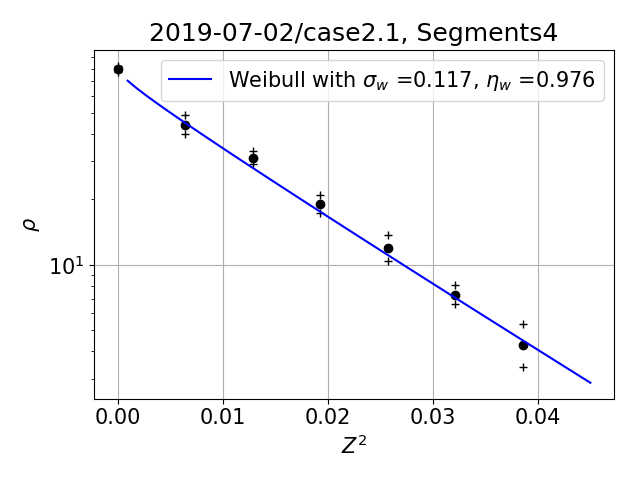

In [69]:
# Graph the probability
plt.figure()
fontsize = 15
plt.rcParams.update({'font.size': fontsize})
plt.semilogy(bins, counts, 'ok')
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')
plt.title(case_and_folder + ', ' + Segmentname)
plt.xlabel(r'$Z^{2}$')
plt.ylabel(r'$\rho$')
plt.grid(True)

# Graph the best-fit probability
myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)
plt.semilogy(Z2theory, myWeibull, 'b', \
             label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ', $\eta_w$ =' + str(etaW)[0:5])
plt.legend(fontsize=fontsize)

In [70]:
plt.savefig(Roughnessfilename)